In [1]:
!pip install umap-learn
!pip install hdbscan
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 43.8 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata (3.1 kB)
Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=819466 sha256=330cf0089036c51b975668b7fc70123b325528e159e1e627497a583166d7f4d8
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.8
    Uninstalling Cython-3.0.8:
      Successfully uninstalled Cython-3.0.8


In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
import hdbscan

import torch.nn.functional as F
import torch

from torch import Tensor
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

import umap

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

2024-05-18 10:05:08.738301: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 10:05:08.738396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 10:05:08.871531: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
table_path = "/kaggle/input/full-processed-dataset-csv/full_processed_dataset.csv"
data = pd.read_csv(table_path)
data.dropna(axis=0, how='any', inplace=True)
data.parsed_text = data.parsed_text.astype(str)

data.head()

,url,base_category_nm,parsed_text
0,https://aspect-school.ru,Образование,курс маникюр школа обучение ученик мастер ногт...
1,https://rlagency.ru,Развлечения,билет купить руб подробный любовь дк павлово с...
2,https://kozlovatravel.u-on.ru,Развлечения,Автоматизированная система U ON Travel Забыли ...
3,https://rootsyou.tilda.ws,Красота,крем мыло баттеры аромароллер косметика душа п...
4,https://esk.one/p/wadgpcigy2vveo,Образование,прототип блок схема поддержка mind esk one сер...


In [5]:
lol = []
for i in range(data.shape[0]):
    if data.loc[i, 'parsed_text'].find('Страница входа Восстановить Зарегистрироваться') != -1:
        lol.append(i)
print(lol)

[87, 133, 230, 568, 785, 795, 1075, 1216, 1361, 1365, 1638, 1658, 1953, 2061, 2301, 2360, 2519, 2696, 3162, 3186, 3236, 3376, 4330, 4577, 4680, 4882, 4923, 5079, 5173, 5225, 5266, 5303, 5626, 5694, 5740, 5994, 6067, 6232, 6233, 6513, 7210, 7651, 8013, 8041, 8059, 8097, 8101, 8434, 8509, 8552, 8902, 8934, 9094, 9133, 9184, 9369, 9453, 9464, 9575, 9621, 9775, 9864, 9865, 10375, 10425, 10538, 10663, 10711, 10768, 10857, 10868, 11489, 11538, 11568, 11701, 11784, 11919, 12251, 12295, 12320, 12511, 12554, 12644, 12837, 13174, 13203, 13378, 14085, 14376, 14405, 14552, 14719, 15068, 15206, 15251, 15270, 15815, 15959, 15994, 16377, 16435, 16849, 16947, 16999, 17426, 17707, 17779, 17808, 18204, 18273, 18602, 18758, 18821, 18994, 19279, 19609, 19975, 20083, 20227, 20418, 20435, 20563, 20685, 20802, 21165, 21229, 21464, 21499, 21527, 21532, 21586, 21646, 21903, 22078, 22088, 22259, 22965, 22974, 23037, 23105, 23189, 23193, 23372, 23799, 23825, 23978, 24151, 24270, 24292, 24900, 24908, 25125, 25216

In [6]:
data.loc[lol, :]

,url,base_category_nm,parsed_text
87,https://lk.masha.fit,Образование,Страница входа Восстановить Зарегистрироваться...
133,https://course.kaina.ru,Образование,Страница входа Восстановить Зарегистрироваться...
230,https://kurs.speechka.online,Образование,Страница входа Восстановить Зарегистрироваться...
568,https://dociureva.com,Образование,Страница входа Восстановить Зарегистрироваться...
785,https://kurs.smolyaninovablog.ru,Образование,Страница входа Восстановить Зарегистрироваться...
...,...,...,...
36386,https://turkeeva.ru,Образование,Страница входа Восстановить Зарегистрироваться...
36687,https://kidspravo.ru,Цифровые услуги,Страница входа Восстановить Зарегистрироваться...
36701,https://tatiananovinskaya.ru,Образование,Страница входа Восстановить Зарегистрироваться...
36935,https://larina-m.ru,Образование,Страница входа Восстановить Зарегистрироваться...


In [7]:
data.drop(index=lol, inplace=True)

In [8]:
data['base_category_nm'].unique()

array(['Образование', 'Развлечения', 'Красота',
       'Продажа различных товаров', 'Авиабилеты', 'Одежда',
       'Дом и ремонт', 'Одежда и аксессуары', 'Связь и телеком',
       'Медицина', 'Салоны красоты и здоровья',
       'Электроника и бытовая техника', 'Различные услуги',
       'Подарки и сувениры', 'Цифровые услуги',
       'Заведения общественного питания', 'Автозапчасти и автосервисы',
       'Спорт', 'Зоомагазины и ветеринарные клиники', 'Транспорт',
       'Продукты', 'Рукоделие и творчество',
       'Адвокаты и юридические услуги', 'Ювелирные изделия и часы',
       'Книги и канцтовары', 'Отели', 'Печать и сканирование',
       'Танцевальные залы, школы и студии', 'Финансовые услуги', 'Цветы',
       'Магазины игрушек и хобби-товаров', 'Ремонт компьютеров',
       'Жилищно-коммунальные услуги', 'Аптеки', 'Спорттовары',
       'Курьерские услуги', 'Фотостудии', 'Оптика', 'Топливо',
       'Химчистка', 'Ателье и ремонт одежды', 'Ломбарды',
       'Клубы видеоигр', 'Бары, п

In [9]:
tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large').to(device)

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

In [10]:
data['text'] = data['parsed_text'].apply(lambda x: "query: " + x)
data.head()

,url,base_category_nm,parsed_text,text
0,https://aspect-school.ru,Образование,курс маникюр школа обучение ученик мастер ногт...,query: курс маникюр школа обучение ученик маст...
1,https://rlagency.ru,Развлечения,билет купить руб подробный любовь дк павлово с...,query: билет купить руб подробный любовь дк па...
2,https://kozlovatravel.u-on.ru,Развлечения,Автоматизированная система U ON Travel Забыли ...,query: Автоматизированная система U ON Travel ...
3,https://rootsyou.tilda.ws,Красота,крем мыло баттеры аромароллер косметика душа п...,query: крем мыло баттеры аромароллер косметика...
4,https://esk.one/p/wadgpcigy2vveo,Образование,прототип блок схема поддержка mind esk one сер...,query: прототип блок схема поддержка mind esk ...


In [11]:
dataset = Dataset.from_pandas(data[data["base_category_nm"] == 'Образование'])

In [12]:
%%time

TEST_SIZE = 0.3
SPLIT_RANDOM_SEED = 42
MAX_LENGTH = 512

# batch_dict = dataset.map(encode, batched=True, remove_columns="text")
batch_dict = tokenizer(dataset["text"], max_length=512, padding=True, truncation=True, return_tensors='pt')

trans_dataset = TensorDataset(batch_dict['input_ids'], batch_dict['attention_mask'])

CPU times: user 7.06 s, sys: 401 ms, total: 7.46 s
Wall time: 3.48 s


In [13]:
batch_size = 1
data_loader = DataLoader(trans_dataset, batch_size=batch_size, shuffle=False)

In [18]:
%%time

def average_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

model.eval()
result = None
for input_ids, attention_mask in tqdm(data_loader, desc=f'Trans'):
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    out = model(input_ids, attention_mask=attention_mask)
    embeddings = average_pool(out.last_hidden_state, attention_mask)

    res = embeddings.cpu().detach().numpy().astype("float")
    if result is None:
        result = res.copy()
    else:
        result = np.append(result, res, axis=0)

Trans: 100%|██████████| 8364/8364 [10:54<00:00, 12.77it/s]

CPU times: user 10min 40s, sys: 15.5 s, total: 10min 56s
Wall time: 10min 54s


In [19]:
result.shape

(8364, 1024)

In [22]:
scaled_penguin_data = StandardScaler().fit_transform(result)


In [23]:
%%time

reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_penguin_data)
embedding.shape

CPU times: user 56.7 s, sys: 1.17 s, total: 57.8 s
Wall time: 31.7 s


(8364, 2)

In [24]:
import gc
torch.cuda.empty_cache()
gc.collect()

152380

# Перебираем параметры SpectralClustering

param: n_clusters,default = 8

In [28]:
colors = ['#000000', '#ff0000', '#00ff00', '#0000ff', '#ff9900', '#99cc00',
'#cc00cc', '#ffcc00', '#33ccff', '#009900', '#cc99cc', '#ff3300',
'#66ffcc', '#99ffcc', '#ffcc99', '#ff9999', '#cccccc', '#993366',
'#ffcc66', '#669999', '#ff6600', '#6633ff', '#9966ff', '#6699cc',
'#339933']

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited at iteration 628 with accuracies 
[4.79556706e-16 6.34892819e-06 1.41662419e-05 4.49137335e-05
 1.27150327e-05]
not reaching the requested tolerance 1.4901161193847656e-05.
Use iteration 555 instead with accuracy 
7.965773857053014e-06.

  _, diffusion_map = lobpcg(
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited postprocessing with accuracies 
[1.13723879e-15 5.75976135e-06 6.16299905e-06 7.72147187e-06
 2.01846648e-05]
not reaching the requested tolerance 1.4901161193847656e-05.
  _, diffusion_map = lobpcg(


{0, 1, 2, 3}
Counter({0: 997, 2: 1, 3: 1, 1: 1})


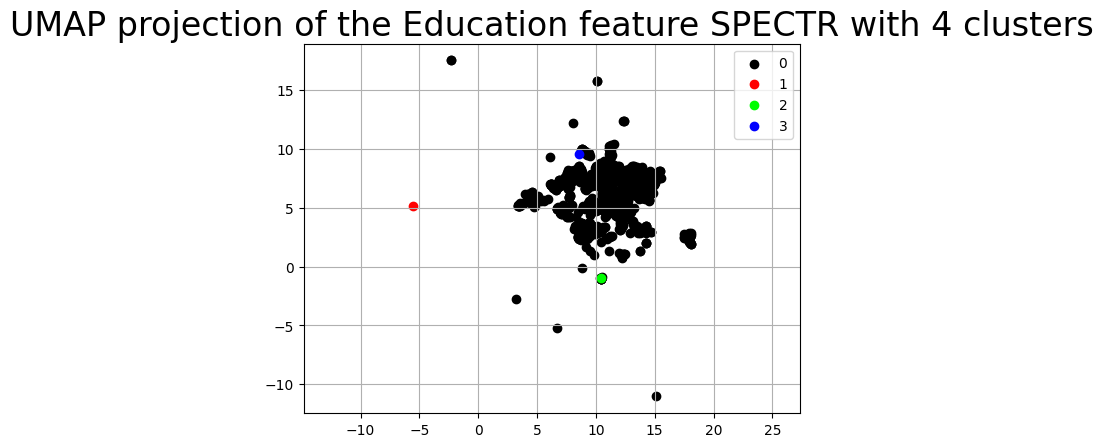

{0, 1, 2, 3, 4, 5}
Counter({0: 995, 4: 1, 3: 1, 2: 1, 1: 1, 5: 1})


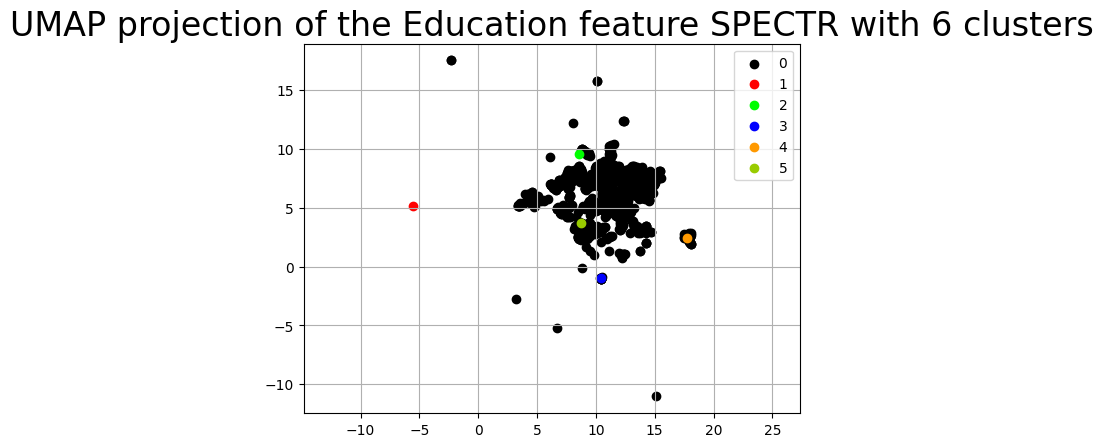

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited at iteration 1306 with accuracies 
[2.83829973e-15 4.31851751e-06 6.49684866e-06 6.28479377e-06
 1.18458704e-05 1.57080728e-05 7.29044486e-06 6.95863042e-06
 1.45307253e-05]
not reaching the requested tolerance 1.4901161193847656e-05.
Use iteration 1266 instead with accuracy 
8.121801736671834e-06.

  _, diffusion_map = lobpcg(
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited postprocessing with accuracies 
[1.25448964e-15 4.20030742e-06 6.42749483e-06 6.35957388e-06
 1.10292666e-05 1.54578189e-05 7.16173402e-06 7.04055938e-06
 1.54088992e-05]
not reaching the requested tolerance 1.4901161193847656e-05.
  _, diffusion_map = lobpcg(


{0, 1, 2, 3, 4, 5, 6, 7}
Counter({0: 991, 7: 3, 4: 1, 2: 1, 3: 1, 1: 1, 5: 1, 6: 1})


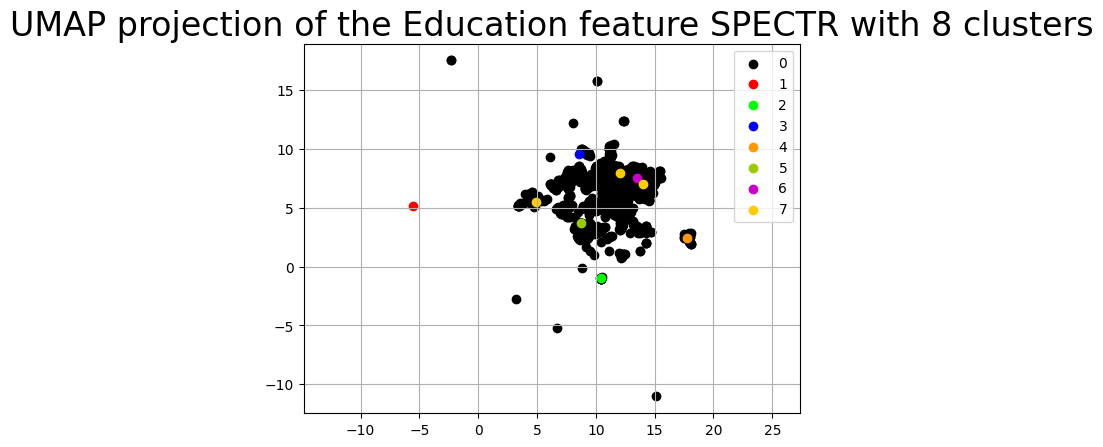

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:420: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  est = KMeans(


{0, 1, 2, 3, 4, 5, 6, 7, 8}
Counter({0: 982, 5: 6, 7: 4, 8: 3, 4: 1, 2: 1, 3: 1, 1: 1, 6: 1})


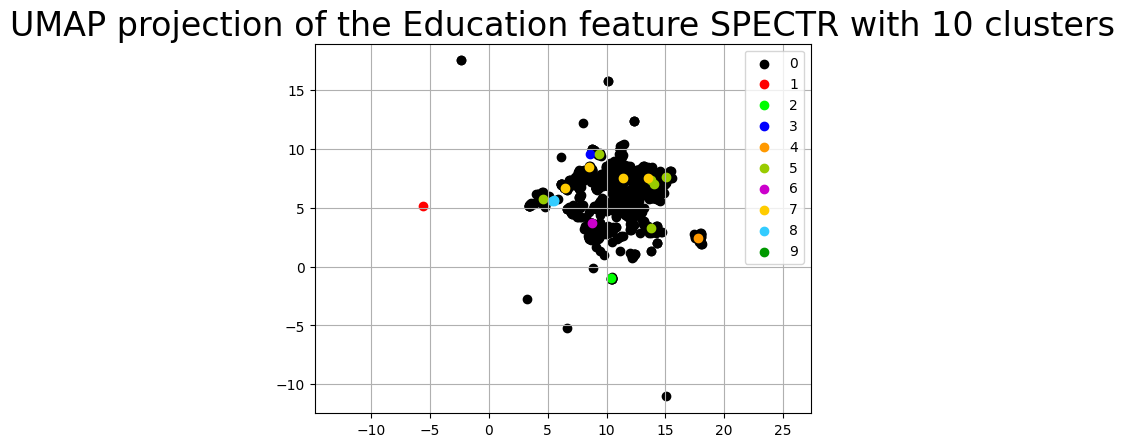

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited at iteration 1152 with accuracies 
[3.92791360e-14 2.59220357e-06 1.86777517e-06 1.73792815e-06
 1.76563432e-06 3.61012021e-06 4.16341804e-06 2.92367500e-06
 8.38750832e-06 1.77848674e-05 1.47015113e-05 1.11836971e-05
 1.54394028e-05]
not reaching the requested tolerance 1.4901161193847656e-05.
Use iteration 1152 instead with accuracy 
6.627518570947508e-06.

  _, diffusion_map = lobpcg(
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited postprocessing with accuracies 
[3.30161060e-14 2.59220001e-06 1.86777564e-06 1.73792621e-06
 1.76558989e-06 3.61013276e-06 4.16339095e-06 2.92336259e-06
 8.38703245e-06 1.77891798e-05 1.46966246e-05 1.11837015e-05
 1.54394116e-05]
not reaching the requested tolerance 1.4901161193847656e-05.
  _, diffusion_map = lobpcg(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:420: Conve

{0, 1, 2, 3, 4, 5, 6, 8, 9}
Counter({6: 980, 0: 12, 9: 2, 4: 1, 3: 1, 2: 1, 1: 1, 5: 1, 8: 1})


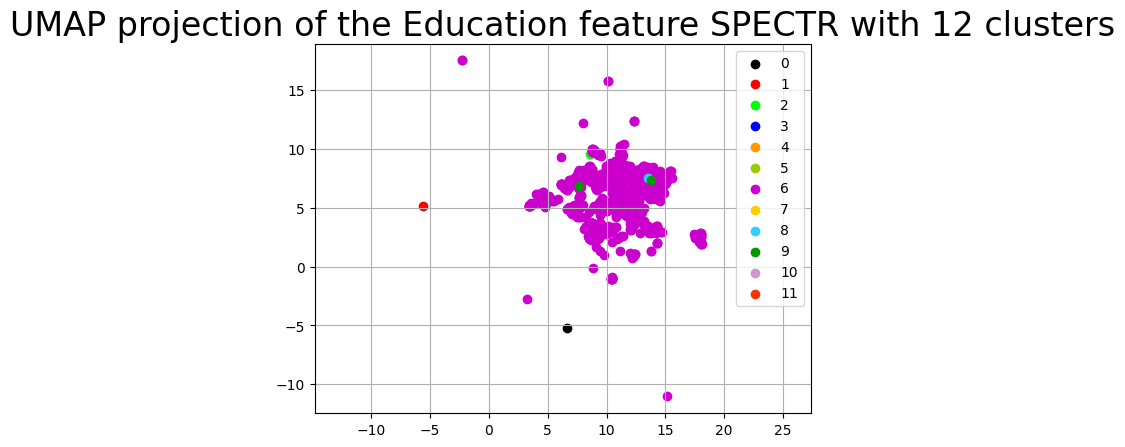

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:420: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  est = KMeans(


{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11}
Counter({6: 982, 0: 4, 8: 3, 11: 2, 7: 2, 10: 2, 4: 1, 3: 1, 2: 1, 1: 1, 5: 1})


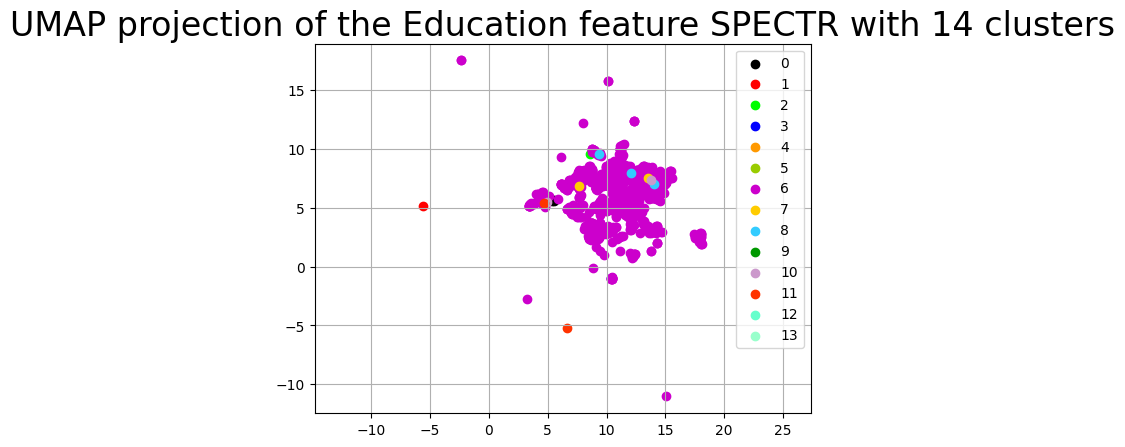

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited at iteration 1458 with accuracies 
[8.47417889e-12 2.18408568e-06 1.73888705e-06 1.82366035e-06
 1.73566132e-06 1.94231923e-06 3.82533000e-06 2.88068624e-06
 3.79271080e-06 3.87788429e-06 4.51800485e-06 5.38449965e-06
 2.98413768e-06 7.03558625e-06 1.44461804e-05 1.52074889e-05
 1.24678107e-05]
not reaching the requested tolerance 1.4901161193847656e-05.
Use iteration 1458 instead with accuracy 
5.049702464180429e-06.

  _, diffusion_map = lobpcg(
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited postprocessing with accuracies 
[2.38429961e-12 2.16958329e-06 1.75801918e-06 1.83490613e-06
 1.69283764e-06 1.97656660e-06 3.81682704e-06 2.88360281e-06
 3.79277571e-06 3.87856776e-06 4.51340976e-06 5.39617159e-06
 2.98153881e-06 7.03384305e-06 1.44495060e-05 1.52007147e-05
 1.24708438e-05]
not reaching the requested tolerance 1.490116

{0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15}
Counter({12: 974, 0: 11, 11: 2, 10: 2, 6: 2, 8: 1, 4: 1, 9: 1, 2: 1, 3: 1, 15: 1, 1: 1, 13: 1, 5: 1})


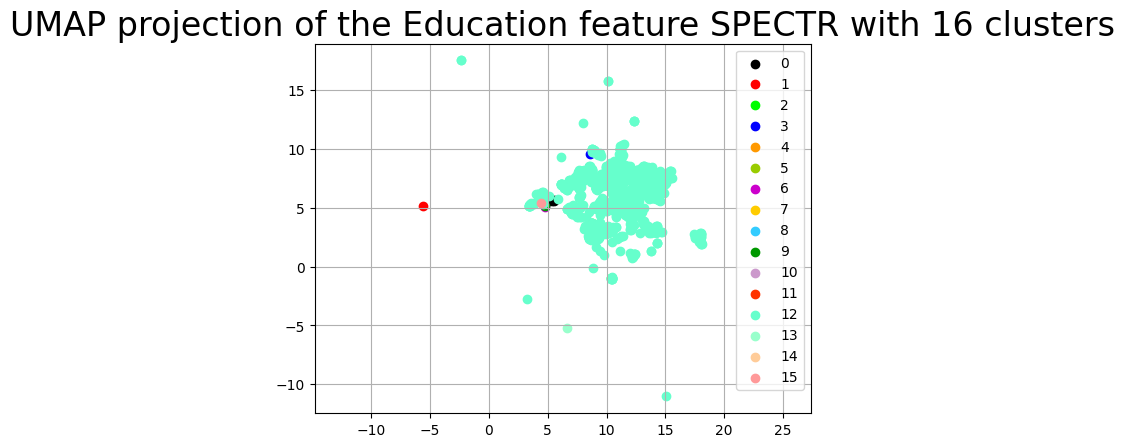

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited at iteration 590 with accuracies 
[7.94132871e-12 1.51372816e-06 1.91308568e-06 1.05902082e-06
 1.16123039e-06 1.61790296e-06 2.63711960e-06 2.61444584e-06
 4.78820397e-06 9.84697922e-06 3.26305479e-06 1.09454945e-05
 1.03307608e-05 1.47954941e-05 3.33082920e-05 6.25063447e-06
 1.31545468e-05 1.42560703e-05 8.86161781e-06]
not reaching the requested tolerance 1.4901161193847656e-05.
Use iteration 590 instead with accuracy 
7.490404748057942e-06.

  _, diffusion_map = lobpcg(
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited postprocessing with accuracies 
[7.93749907e-13 1.51423921e-06 1.91337564e-06 1.05879319e-06
 1.16355936e-06 1.61827119e-06 2.63968037e-06 2.61898290e-06
 4.78857504e-06 9.85147667e-06 3.26310254e-06 1.09433608e-05
 1.03296725e-05 1.47950307e-05 3.33088266e-05 6.24869406e-06
 1.31518156e-05 1.42562272e-05 8.8

{1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 16}
Counter({4: 980, 16: 7, 7: 3, 13: 2, 11: 1, 8: 1, 3: 1, 5: 1, 2: 1, 1: 1, 6: 1, 12: 1})


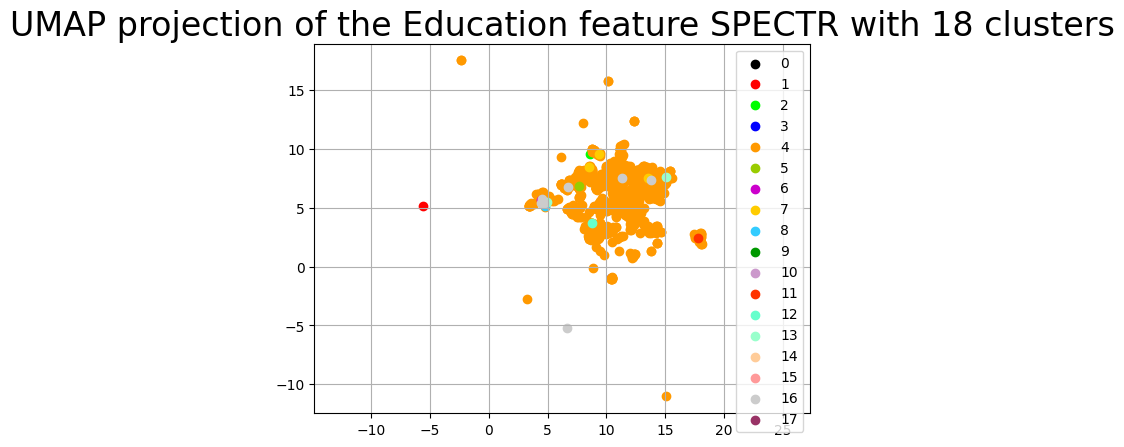

In [30]:
from collections import Counter


for i in range(4, 20, 2):
  spectr = SpectralClustering(n_clusters=i, n_jobs=-1).fit(result[:1000])
  print(set(spectr.labels_))
  print(Counter(spectr.labels_))

  fig, ax = plt.subplots()
  for lbl in np.arange(0, i):
      ax.scatter(
          embedding[:1000][spectr.labels_ == lbl][:, 0],
          embedding[:1000][spectr.labels_ == lbl][:, 1],
          c=colors[lbl],
          label=lbl)

  ax.legend()
  ax.grid(True)

  plt.gca().set_aspect('equal', 'datalim')
  plt.title(f'UMAP projection of the Education feature SPECTR with {i} clusters', fontsize=24)

  plt.show()


In [ ]:
from collections import Counter


spectr = SpectralClustering(n_clusters=12, 
                            n_jobs=-1).fit(result)
print(set(spectr.labels_))
print(Counter(spectr.labels_))

fig, ax = plt.subplots()
for lbl in np.arange(0, 8):
  ax.scatter(
      embedding[:1000][spectr.labels_ == lbl][:, 0],
      embedding[:1000][spectr.labels_ == lbl][:, 1],
      c=sns.color_palette()[lbl],
      label=lbl)

ax.legend()
ax.grid(True)

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'UMAP projection of the Education feature SPECTR with {i} clusters', fontsize=24)

plt.show()


In [ ]:
data[data["base_category_nm"] == 'Образование'][:1000][spectr.labels_ == 7]